# Working with Apache Spark using pyspark

# ~ Install spark and pyspark

Install spark on your server

<code> sudo apt install spark </code>

*spark can be accessed from command line using the spark-shell command (here the shell acts as a driver program)*

<code> spark-shell -c spark.driver.bindAddress=127.0.0.1 </code>


Install the pyspark package using pip

<code> pip install pyspark </code>





In [1]:
pip show pyspark

Name: pyspark
Version: 3.1.2
Summary: Apache Spark Python API
Home-page: https://github.com/apache/spark/tree/master/python
Author: Spark Developers
Author-email: dev@spark.apache.org
License: http://www.apache.org/licenses/LICENSE-2.0
Location: /home/iitp/anaconda3/lib/python3.8/site-packages
Requires: py4j
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [2]:
import random, os, shutil
import numpy as np
import matplotlib.pyplot as plt
import pyspark

# Create spark session

a spark session must be created before working with spark.

In [3]:
# we need to start a spark session
from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.appName('Lab6').getOrCreate()
spark

# The *context* object

In [4]:
sc = spark.sparkContext
print('sparkContext:',sc)

sparkContext: <SparkContext master=local[*] appName=Lab6>


# RDD - Resilient Distributed Datasets
 RDDs are **immutable** collection of datasets that work in parallel<br>
  read more@ https://spark.apache.org/docs/latest/rdd-programming-guide.html#resilient-distributed-datasets-rdds
 
* **Transformations** are lazy operations on RDDs - stores actions (in a DAG) rather than actual transformation
    * read more@ https://spark.apache.org/docs/latest/rdd-programming-guide.html#transformations
* **Actions** on RDDs produce results (using the RDD DAG)
    * read more@ https://spark.apache.org/docs/latest/rdd-programming-guide.html#actions

In [6]:
help(pyspark.RDD)

Help on class RDD in module pyspark.rdd:

class RDD(builtins.object)
 |  RDD(jrdd, ctx, jrdd_deserializer=AutoBatchedSerializer(PickleSerializer()))
 |  
 |  A Resilient Distributed Dataset (RDD), the basic abstraction in Spark.
 |  Represents an immutable, partitioned collection of elements that can be
 |  operated on in parallel.
 |  
 |  Methods defined here:
 |  
 |  __add__(self, other)
 |      Return the union of this RDD and another one.
 |      
 |      Examples
 |      --------
 |      >>> rdd = sc.parallelize([1, 1, 2, 3])
 |      >>> (rdd + rdd).collect()
 |      [1, 1, 2, 3, 1, 1, 2, 3]
 |  
 |  __getnewargs__(self)
 |  
 |  __init__(self, jrdd, ctx, jrdd_deserializer=AutoBatchedSerializer(PickleSerializer()))
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  aggregate(self, zeroValue, seqOp, combOp)
 |      Aggregate the elements of each partition, and then the results for all
 |      the part

# Creating RDDs

## creating from sc.parallelize()

In [7]:
RDD_array1 = sc.parallelize(np.random.randint(0,10,size=10))

## apply transformation and actions

In [8]:
RDD_array2 = RDD_array1.map(lambda x: x*2) # 'map' is a transformation

In [9]:
a1 = RDD_array1.collect() # 'collect' is an action
a2 = RDD_array2.collect()
print( a1,  a2)

[7, 9, 2, 0, 4, 1, 2, 0, 5, 0] [14, 18, 4, 0, 8, 2, 4, 0, 10, 0]


In [10]:
a3 = RDD_array2.reduce(lambda x,y: x+y)  # 'reduce' is an action
print(a3)

60


## creating from files or external objects

In [11]:
RDD_F = sc.textFile("Apple_stock.csv")

In [12]:
cf = RDD_F.count() # 'count' is an action
print('Count:',cf)

data = RDD_F.collect() # 'collect' is an action
print(type(data), len(data))

samples = RDD_F.takeSample(True, 3)  # takeSample is an action
print('Samples\n', type(samples), len(samples), samples)

first = RDD_F.first()
print('Header:',first) #<---- shall be used for schema

Count: 1597
<class 'list'> 1597
Samples
 <class 'list'> 3 ['2015-11-16,28.559999465942383,27.75,27.844999313354492,28.545000076293945,152426800.0,26.322452545166016', '2011-01-03,11.795000076293945,11.601428985595703,11.630000114440918,11.770357131958008,445138400.0,10.106220245361328', '2012-09-10,24.403213500976562,23.64642906188965,24.301786422729492,23.669286727905273,487998000.0,20.410099029541016']
Header: Date,High,Low,Open,Close,Volume,Adj Close


# mapper function used to map values to data frame

In [13]:
def mapper(xs):
    global first
    if xs!=first:
        x = xs.split(",")
        return [str(x[0]), float(x[1]), float(x[2]), float(x[3]), float(x[4]), float(x[5]), float(x[6])]
    else:
        pass

## create data frame using mapper

In [14]:
dataset = RDD_F.map(mapper).filter(lambda x: x!=None).toDF(first.split(','))
print(type(dataset), dataset.count())
dataset.printSchema()
dataset.show() # or use .describe()

<class 'pyspark.sql.dataframe.DataFrame'> 1596
root
 |-- Date: string (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- Adj Close: double (nullable = true)

+----------+-----------------+-----------------+-----------------+-----------------+----------+------------------+
|      Date|             High|              Low|             Open|            Close|    Volume|         Adj Close|
+----------+-----------------+-----------------+-----------------+-----------------+----------+------------------+
|2010-08-02|9.378213882446289|9.272143363952637| 9.30142879486084|9.351785659790039|4.280556E8| 8.029596328735352|
|2010-08-03|9.402142524719238|9.265000343322754|9.321785926818848|9.354642868041992|4.176536E8| 8.032052993774414|
|2010-08-04|9.438570976257324|9.296786308288574|  9.3871431350708|9.392143249511719|4.203752E8| 8.064249038696289

# Linear Regression Example

*Not using spark.mllib*

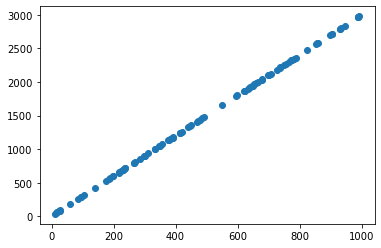

In [15]:
# a line is y = mx + c where m and c are the params
ground_m, ground_c = random.randint(0,5), random.randint(0,5) # the ground truth

def line(x):
    global ground_m, ground_c
    return ground_m*x + ground_c

# generate at least 100 samples and save to a file 
rdd_x = sc.parallelize(np.random.randint(0,1000,size=100))
rdd_y = rdd_x.map(line)

# generate input data and save to file
data_x, data_y = rdd_x.collect(), rdd_y.collect() #<-- 'collect' is an action
plt.scatter(data_x, data_y)
plt.show()

## Estimate using keras

In [16]:
from tensorflow.keras import Model  # always use this approach instead of Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# create a single layer model
input_layer = Input((1,))
output_layer = Dense(1)(input_layer)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mse', optimizer=Adam(learning_rate=0.1), metrics=[])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


# Train model

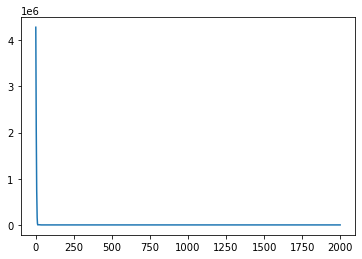

In [17]:
lossv=[]
for ep in range(100):
    #print(ep+1)
    hist=model.fit(x=np.array(rdd_x.collect()), #<--- new data every time collect() is called
                   y=np.array(rdd_y.collect()), 
                   batch_size=32, epochs=20,verbose=0)
    lossv.extend(hist.history['loss'])
plt.plot(lossv)

# Check for convergence

check if estimated parameters are close enough to ground truth

In [18]:
model_w8 = model.get_weights()
est_m, est_c = model_w8[0][0],model_w8[1][0]
print('Model Estimate:', est_m, est_c)
print('Ground Truth:','['+str(ground_m)+']', ground_c)

print('Delta:',ground_m-est_m, ground_c-est_c)

Model Estimate: [3.] 3.9999743
Ground Truth: [3] 4
Delta: [0.] 2.574920654296875e-05


# Using spark DataFrames in general

# Reading Data

In [19]:
dataset = spark.read.option('header',
                            'true' #<---- the csv has a header
                           ).csv("Apple_stock.csv", 
                                inferSchema=True) # add infer schema to load in proper data type

print(type(dataset), dataset.count())
dataset.printSchema()
dataset.show() # or use .describe()

<class 'pyspark.sql.dataframe.DataFrame'> 1596
root
 |-- Date: string (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- Adj Close: double (nullable = true)

+----------+-----------------+-----------------+-----------------+-----------------+----------+------------------+
|      Date|             High|              Low|             Open|            Close|    Volume|         Adj Close|
+----------+-----------------+-----------------+-----------------+-----------------+----------+------------------+
|2010-08-02|9.378213882446289|9.272143363952637| 9.30142879486084|9.351785659790039|4.280556E8| 8.029596328735352|
|2010-08-03|9.402142524719238|9.265000343322754|9.321785926818848|9.354642868041992|4.176536E8| 8.032052993774414|
|2010-08-04|9.438570976257324|9.296786308288574|  9.3871431350708|9.392143249511719|4.203752E8| 8.064249038696289

In [20]:
dataset.select(['Date','Volume']).show()

+----------+----------+
|      Date|    Volume|
+----------+----------+
|2010-08-02|4.280556E8|
|2010-08-03|4.176536E8|
|2010-08-04|4.203752E8|
|2010-08-05|2.890972E8|
|2010-08-06|4.448976E8|
|2010-08-09| 3.03128E8|
|2010-08-10|  4.5192E8|
|2010-08-11|6.200544E8|
|2010-08-12|5.349204E8|
|2010-08-13|3.548692E8|
|2010-08-16|  3.1843E8|
|2010-08-17|4.226404E8|
|2010-08-18| 3.39696E8|
|2010-08-19| 4.26706E8|
|2010-08-20|  3.8423E8|
|2010-08-23|4.140416E8|
|2010-08-24|6.025656E8|
|2010-08-25|5.968676E8|
|2010-08-26|4.665052E8|
|2010-08-27|5.483912E8|
+----------+----------+
only showing top 20 rows



# Filter Operation

In [21]:
dataset.filter("Volume>=400000000").select(["Date","Volume","Adj Close"]).show()

+----------+----------+------------------+
|      Date|    Volume|         Adj Close|
+----------+----------+------------------+
|2010-08-02|4.280556E8| 8.029596328735352|
|2010-08-03|4.176536E8| 8.032052993774414|
|2010-08-04|4.203752E8| 8.064249038696289|
|2010-08-06|4.448976E8| 7.975627899169922|
|2010-08-10|  4.5192E8| 7.954774856567383|
|2010-08-11|6.200544E8| 7.672046184539795|
|2010-08-12|5.349204E8|7.7211103439331055|
|2010-08-17|4.226404E8| 7.726629257202148|
|2010-08-19| 4.26706E8| 7.662538051605225|
|2010-08-23|4.140416E8|7.5374250411987305|
|2010-08-24|6.025656E8| 7.357422828674316|
|2010-08-25|5.968676E8| 7.448192596435547|
|2010-08-26|4.665052E8| 7.368154048919678|
|2010-08-27|5.483912E8| 7.409246921539307|
|2010-08-31|4.207868E8|7.4546308517456055|
|2010-09-01|6.970376E8|7.6763386726379395|
|2010-09-02|4.154276E8| 7.732760429382324|
|2010-09-03|5.207888E8| 7.935146808624268|
|2010-09-08|5.265512E8| 8.062408447265625|
|2010-09-09|4.385752E8| 8.067007064819336|
+----------